# Introduction

## Import Libraries

In [99]:
%matplotlib inline

import pandas as pd
import numpy as np

import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
import glob
import os

import sys
import itertools
from matplotlib import rcParams

from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

from statsmodels.tsa.seasonal import seasonal_decompose

import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error as MAE
from scipy.stats import skew

import folium
from folium.plugins import MarkerCluster

import wellapplication as wa

import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)

rcParams['figure.figsize'] = 15, 10
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 14

In [100]:
llpath = "G:/My Drive/Python/Pycharm/loggerloader/"
sys.path.append(llpath)
import loggerloader as ll

## Database Connection

In [101]:
import importlib.util
spec = importlib.util.spec_from_file_location("dbconnect", "G:/My Drive/Python/dbconnect.py")
dbconnect = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dbconnect)
engine = dbconnect.postconn_ugs()

## Folder Paths

In [159]:
savefold = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"
figfold = "G:/My Drive/WORK/Leland_Harris/figures/"
file_place = "G:/My Drive/WORK/Leland_Harris/intermediate_data/"

## Import Data

In [160]:
#dfpiv = pd.read_pickle(savefold+"pivotedwells.pickle")
dfpiv = pd.read_pickle(savefold+"raw_hydrograph_data.pickle")
climate_data = pd.read_pickle(file_place+'climate_data.pickle')
well_table = pd.read_pickle(savefold+"well_table.pickle")

# Map Well Locations

In [13]:
lh_sites = well_table[well_table.index.isin([
    61, 62, 63, 64, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020,
    1061, 1064, 1066, 1068, 1069])]
m = folium.Map(location=[lh_sites['latitude'].mean(),
                         lh_sites['longitude'].mean()],
           tiles='OpenStreetMap',
           zoom_start=15)


for site in lh_sites.index:
    folium.Marker([lh_sites.loc[site,'latitude'],
                   lh_sites.loc[site,'longitude']],
                  popup=lh_sites.loc[site,'locationname']).add_to(m)

m

# stldecompose Decomposition

In [119]:
def pull_n_decomp(sites, df, resampleint = '1H',field = 'waterelevation'):
    """
    :sites: list of site ids that you want to pull and analyze from the database
    :returns: dictionary of pandas dataframes with decomposed parts 
    where each dataframe is referenced by its well id as a key
    """
    data = {} # dictionary object to hold data

    for site in sites:
        if site in df.index.get_level_values(0).unique():
            data[site] = df.loc[site].resample(resampleint).mean().interpolate(method='time') # fill gaps and sample to 1hr
            decomp = decompose(data[site][field], period=8766) # decompose series
            # assign variables from decomposition
            data[site]['seasonal'] = decomp.seasonal
            data[site]['trend'] = decomp.trend
            data[site]['residual'] = decomp.resid
    return data
        
def plotdecomp(data,ttext = 'Decomposition',field = 'waterelevation'):       
    fig, ax = plt.subplots(4,1,sharex=True)
    cols = itertools.cycle(['red','green','blue','orange','purple','black','cyan','magenta','olive','navy','gold'])
    for key,value in data.items():
        clr = next(cols)
        ax[0].plot(value.index,value[field], label = key, color=clr)
        ax[1].plot(value.index,value['trend'], label = key, color=clr)
        ax[2].plot(value.index,value['seasonal'], label = key, color=clr)
        ax[3].plot(value.index,value['residual'], label = key, color=clr)
        ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[0].set_title('Raw Data',loc='right')
    ax[0].set_ylabel('Water Elevation (ft)')
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[3].grid()
    ax[1].set_ylabel('Level Change (ft)')
    ax[2].set_ylabel('Level Change (ft)')
    ax[3].set_ylabel('Level Change (ft)')
    ax[1].set_title('Trend',loc='right')
    ax[2].set_title('Seasonal',loc='right')
    ax[3].set_title('Residual',loc='right')
    ax[3].set_xlabel('Time')
    #plt.legend()
    fig.suptitle(ttext,x=0.2,y=0.90,fontsize=12)
    return fig, ax

In [120]:
lhsites = [1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1061, 1064, 1066, 1068, 1069]
sgsites = [61,62,63,64]

dfpiv['readingdate'] = pd.to_datetime(dfpiv['readingdate'])
df = dfpiv.set_index(['locationid','readingdate'])

piez = pull_n_decomp(lhsites, df)
sg25 = pull_n_decomp(sgsites, df)

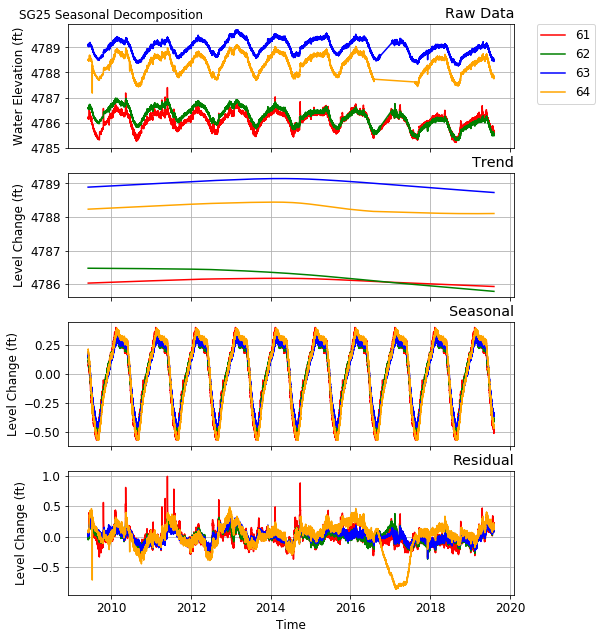

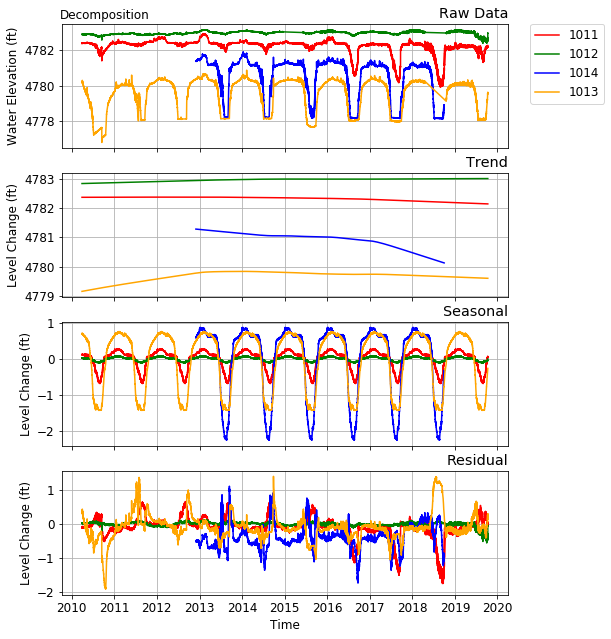

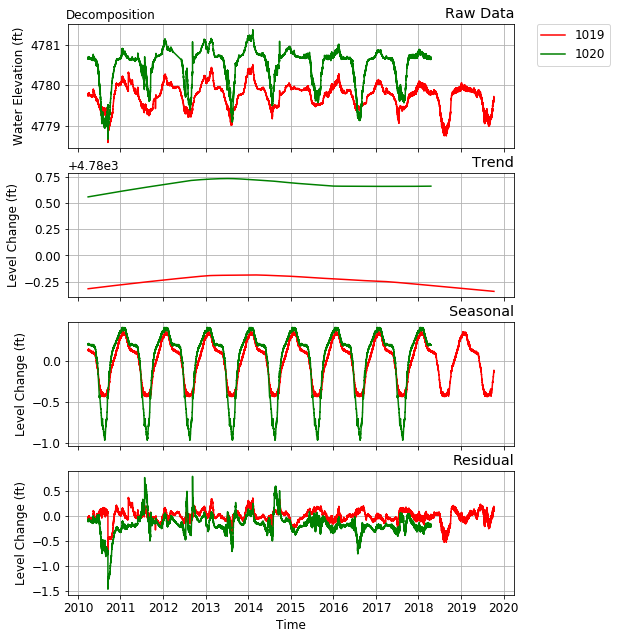

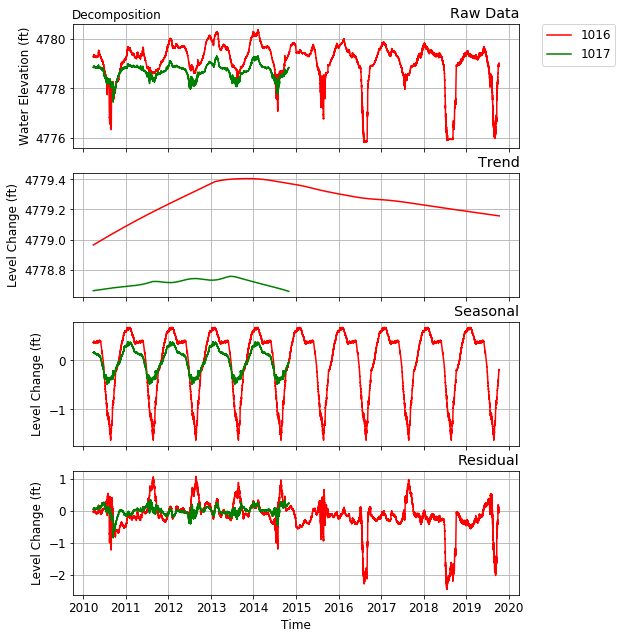

In [121]:
rcParams['figure.figsize'] = 8,10.5
rcParams['font.size'] = 12

fig, ax = plotdecomp(sg25,'SG25 Seasonal Decomposition')
fig.savefig(figfold + 'decomp_sg25.pdf')

#i = 0
#for keys,value in piez.items():
wellsA = [1011,1012,1014,1013]
wellsB = [1019,1020]
wellsC = [1016,1017]

piezshortA = {k: piez[k] for k in wellsA}
fig, ax = plotdecomp(piezshortA)
fig.savefig(figfold+"decomp-{:}-{:}.pdf".format(wellsA[0],wellsA[-1]))

piezshortB = {k: piez[k] for k in wellsB}
fig, ax = plotdecomp(piezshortB)
fig.savefig(figfold+"decomp-{:}-{:}.pdf".format(wellsB[0],wellsB[-1]))

piezshortC = {k: piez[k] for k in wellsC}
fig, ax = plotdecomp(piezshortC)
fig.savefig(figfold+"decomp-{:}-{:}.pdf".format(wellsC[0],wellsC[-1]))
    

# Scipy Trends Analysis

Takka_swe_mm
Wheeler_swe_mm


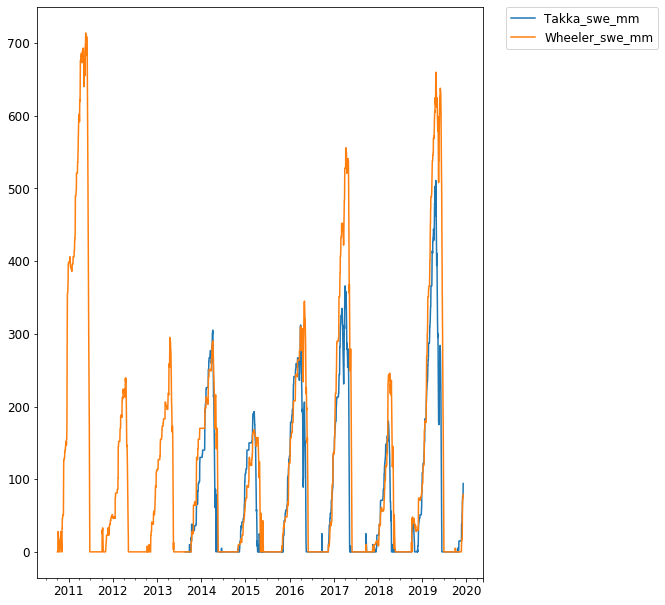

In [183]:
climdata = climate_data['2009-01-01':]
for col in climdata.columns:
    if ('ppt' in col or 'swe' in col or 'snow' in col) and 'accm' not in col and 'incr' not in col:
        
        if 'swe' in col:
            print(col)
            
            df = climdata[col].dropna().resample('1D').mean().interpolate(method='time')
            df.plot(label = col)
            print(col)
            #x = df.index
            #y = df
            #results[col] = seasonal_decompose(df, model='additive',freq=int(round(365.25*24,0)))
            #trend[col] = results[col].trend
            #residual[col] = results[col].resid
            #seasonal[col] = results[site].seasonal
            #results[col].plot()
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [206]:
dfpiv

,readingdate,measuredlevel,temperature,baroefficiencylevel,measureddtw,driftcorrection,waterelevation,locationid
0,2010-03-29 18:00:00,7.369,5.600,0,0.180,-0.000,4782.356,1011
1,2010-03-29 20:00:00,7.315,5.600,0,0.208,-0.000,4782.384,1011
2,2010-03-29 21:00:00,7.315,5.600,0,0.196,-0.000,4782.372,1011
3,2010-03-29 22:00:00,7.358,5.600,0,0.209,-0.000,4782.384,1011
4,2010-03-29 23:00:00,7.361,5.600,0,0.213,-0.000,4782.388,1011
5,2010-03-30 00:00:00,7.361,5.600,0,0.222,-0.000,4782.397,1011
6,2010-03-30 01:00:00,7.346,5.600,0,0.217,-0.000,4782.392,1011
7,2010-03-30 02:00:00,7.335,5.600,0,0.220,-0.000,4782.396,1011
8,2010-03-30 03:00:00,7.320,5.600,0,0.217,-0.000,4782.392,1011
9,2010-03-30 04:00:00,7.299,5.600,0,0.217,-0.000,4782.392,1011


In [211]:
pd.plotting.register_matplotlib_converters()

lhsites = [1011, 1012, 1013, 1014, 1016, 1017, 1019, 1020]
sgsites = ['SG25A','SG25B','SG25C','SG25D']
wellsA = [1011,1012,1013,1014]
wellsB = [1019,1020]
wellsC = [1016,1017]

sg25 = [61, 62, 63, 64]

dfpiv['readingdate'] = pd.to_datetime(dfpiv['readingdate'])
#dfpi = calc_wat_year(dfpiv.set_index(['readingdate'])).reset_index()
df = dfpiv.set_index(['locationid','readingdate'])


trend = {}
seasonal = {}
residual = {}
results = {}



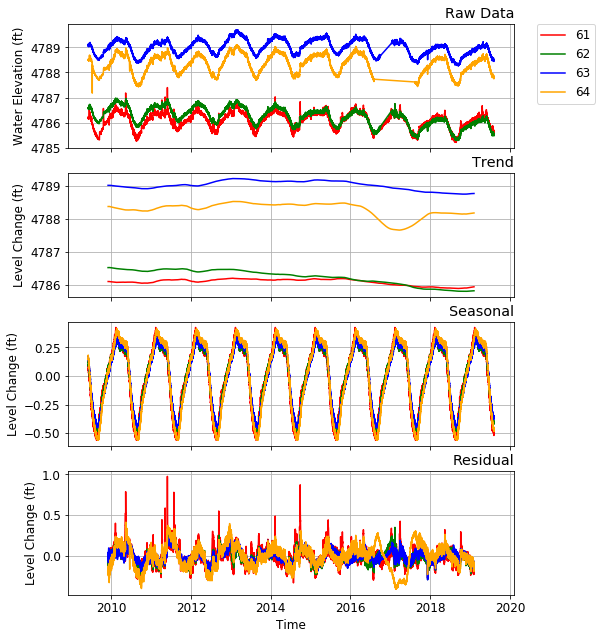

In [212]:
rcParams['figure.figsize'] = 8,10.5
rcParams['font.size'] = 12

fig, ax = plt.subplots(4,1,sharex=True)
cols = itertools.cycle(['red','green','blue','orange','purple','black','cyan','magenta','olive','navy','gold'])

for site in sg25:
    clr = next(cols)
    sdf = df.loc[site,'waterelevation'].dropna().resample('1H').mean().interpolate(method='time')
    results[site] = seasonal_decompose(sdf, model='additive',freq=int(round(365.25*24,0)))
    trend[site] = results[site].trend
    residual[site] = results[site].resid
    seasonal[site] = results[site].seasonal
    ax[0].plot(results[site].observed.index,results[site].observed, label = site, color=clr)
    ax[1].plot(results[site].trend.index,results[site].trend, label = site, color=clr)
    ax[3].plot(results[site].resid.index,results[site].resid, label = site, color=clr)
    ax[2].plot(results[site].seasonal.index,results[site].seasonal, label = site, color=clr)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    ax[3].grid(True)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[0].set_title('Raw Data',loc='right')
    ax[0].set_ylabel('Water Elevation (ft)')
    ax[1].set_ylabel('Level Change (ft)')
    ax[2].set_ylabel('Level Change (ft)')
    ax[3].set_ylabel('Level Change (ft)')
    ax[1].set_title('Trend',loc='right')
    ax[2].set_title('Seasonal',loc='right')
    ax[3].set_title('Residual',loc='right')
    #ax[3].set_xlabel('Time')
plt.xlabel('Time')
#plt.grid()
#plt.title(site)
plt.savefig(figfold+f"scipy_decomp_sg25.pdf")

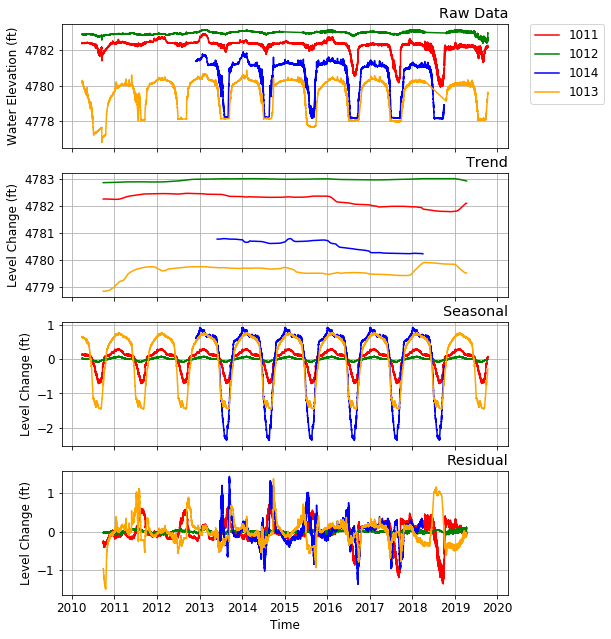

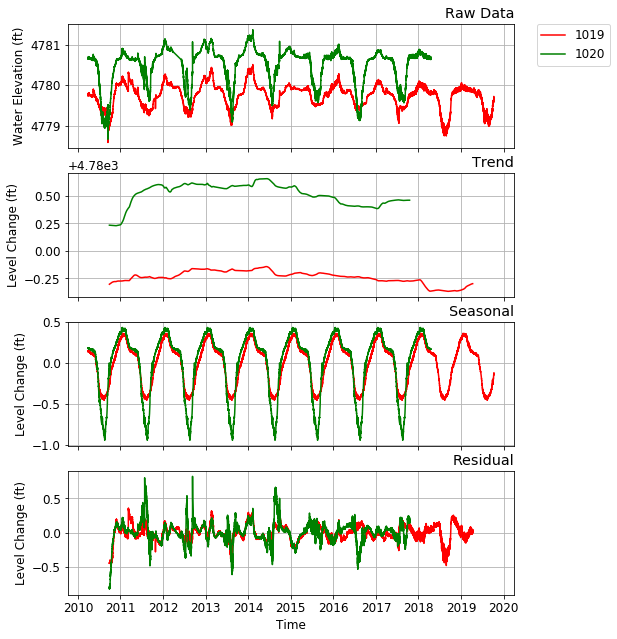

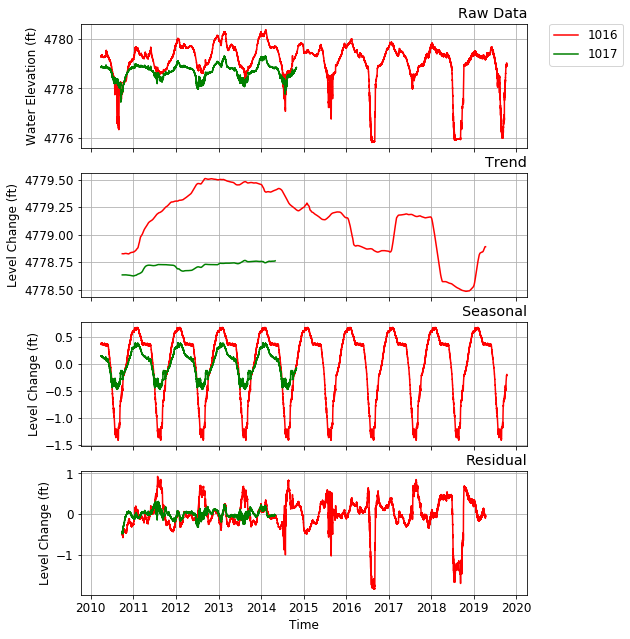

In [213]:
rcParams['figure.figsize'] = 8,10.5
rcParams['font.size'] = 12

wellsA = [1011,1012,1014,1013]
wellsB = [1019,1020]
wellsC = [1016,1017]

rcParams['figure.figsize'] = 8,10.5
rcParams['font.size'] = 12

fig, ax = plt.subplots(4,1,sharex=True)
cols = itertools.cycle(['red','green','blue','orange','purple','black','cyan','magenta','olive','navy','gold'])

for site in wellsA:
    clr = next(cols)
    sdf = df.loc[site,'waterelevation'].dropna().resample('1H').mean().interpolate(method='time')
    results[site] = seasonal_decompose(sdf, model='additive',freq=int(round(365.25*24,0)))
    trend[site] = results[site].trend
    residual[site] = results[site].resid
    seasonal[site] = results[site].seasonal
    ax[0].plot(results[site].observed.index,results[site].observed, label = site, color=clr)
    ax[1].plot(results[site].trend.index,results[site].trend, label = site, color=clr)
    ax[3].plot(results[site].resid.index,results[site].resid, label = site, color=clr)
    ax[2].plot(results[site].seasonal.index,results[site].seasonal, label = site, color=clr)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    ax[3].grid(True)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[0].set_title('Raw Data',loc='right')
    ax[0].set_ylabel('Water Elevation (ft)')
    ax[1].set_ylabel('Level Change (ft)')
    ax[2].set_ylabel('Level Change (ft)')
    ax[3].set_ylabel('Level Change (ft)')
    ax[1].set_title('Trend',loc='right')
    ax[2].set_title('Seasonal',loc='right')
    ax[3].set_title('Residual',loc='right')
    #ax[3].set_xlabel('Time')
plt.xlabel('Time')
#plt.grid()
#plt.title(site)
plt.savefig(figfold+f"scipy_decomp_1011-1014.pdf")


fig, ax = plt.subplots(4,1,sharex=True)
cols = itertools.cycle(['red','green','blue','orange','purple','black','cyan','magenta','olive','navy','gold'])

for site in wellsB:
    clr = next(cols)
    sdf = df.loc[site,'waterelevation'].dropna().resample('1H').mean().interpolate(method='time')
    results[site] = seasonal_decompose(sdf, model='additive',freq=int(round(365.25*24,0)))
    trend[site] = results[site].trend
    residual[site] = results[site].resid
    seasonal[site] = results[site].seasonal
    ax[0].plot(results[site].observed.index,results[site].observed, label = site, color=clr)
    ax[1].plot(results[site].trend.index,results[site].trend, label = site, color=clr)
    ax[3].plot(results[site].resid.index,results[site].resid, label = site, color=clr)
    ax[2].plot(results[site].seasonal.index,results[site].seasonal, label = site, color=clr)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    ax[3].grid(True)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[0].set_title('Raw Data',loc='right')
    ax[0].set_ylabel('Water Elevation (ft)')
    ax[1].set_ylabel('Level Change (ft)')
    ax[2].set_ylabel('Level Change (ft)')
    ax[3].set_ylabel('Level Change (ft)')
    ax[1].set_title('Trend',loc='right')
    ax[2].set_title('Seasonal',loc='right')
    ax[3].set_title('Residual',loc='right')
    #ax[3].set_xlabel('Time')
plt.xlabel('Time')
#plt.grid()
#plt.title(site)
plt.savefig(figfold+f"scipy_decomp_1019-1020.pdf")

fig, ax = plt.subplots(4,1,sharex=True)
cols = itertools.cycle(['red','green','blue','orange','purple','black','cyan','magenta','olive','navy','gold'])

for site in wellsC:
    clr = next(cols)
    sdf = df.loc[site,'waterelevation'].dropna().resample('1H').mean().interpolate(method='time')
    results[site] = seasonal_decompose(sdf, model='additive',freq=int(round(365.25*24,0)))
    trend[site] = results[site].trend
    residual[site] = results[site].resid
    seasonal[site] = results[site].seasonal
    ax[0].plot(results[site].observed.index,results[site].observed, label = site, color=clr)
    ax[1].plot(results[site].trend.index,results[site].trend, label = site, color=clr)
    ax[3].plot(results[site].resid.index,results[site].resid, label = site, color=clr)
    ax[2].plot(results[site].seasonal.index,results[site].seasonal, label = site, color=clr)
    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)
    ax[3].grid(True)
    ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[0].set_title('Raw Data',loc='right')
    ax[0].set_ylabel('Water Elevation (ft)')
    ax[1].set_ylabel('Level Change (ft)')
    ax[2].set_ylabel('Level Change (ft)')
    ax[3].set_ylabel('Level Change (ft)')
    ax[1].set_title('Trend',loc='right')
    ax[2].set_title('Seasonal',loc='right')
    ax[3].set_title('Residual',loc='right')
    #ax[3].set_xlabel('Time')
plt.xlabel('Time')
#plt.grid()
#plt.title(site)
plt.savefig(figfold+f"scipy_decomp_1016-1017.pdf")

## Trends

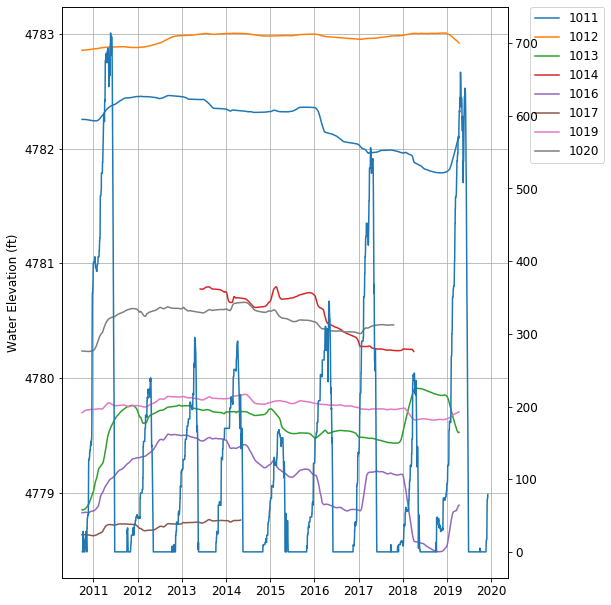

In [217]:
rcParams['figure.figsize'] = 8,10.5
rcParams['font.size'] = 12

trends = pd.concat(trend,axis=1).dropna(how='all')

fig = plt.figure()
for col in trends.columns[4:]:
    plt.plot(trends.index, trends[col], label=col)

plt.ylabel('Water Elevation (ft)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.twinx()
plt.plot(climdata['Wheeler_swe_mm'].index,climdata['Wheeler_swe_mm'])

#plt.savefig(figfold+'scipy_trends-1011-1020.pdf')

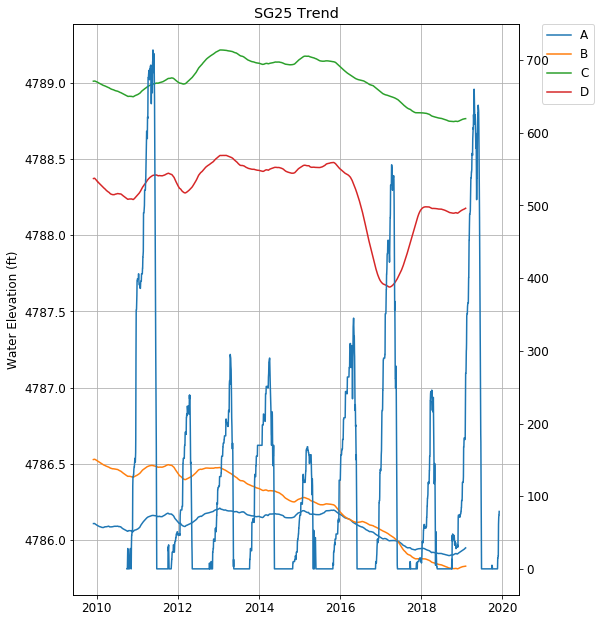

In [218]:
rcParams['figure.figsize'] = 8,10.5
rcParams['font.size'] = 12
sg25m = {61:'A',62:'B',63:'C',64:'D'}
fig = plt.figure()
for col in trends.columns[:4]:
    plt.plot(trends.index, trends[col], label=sg25m.get(col))
plt.ylabel('Water Elevation (ft)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('SG25 Trend')
plt.twinx()
plt.plot(climdata['Wheeler_swe_mm'].index,climdata['Wheeler_swe_mm'])
#plt.savefig(figfold+'scipy_trends-SG25.pdf')